In [687]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import yfinance as yf # ticker data 
from pandas_datareader import data as pdr # market proxy and treasury rates data
import datetime as dt
from numpy import nan
from time import sleep
import concurrent.futures
from functools import reduce
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy 
import time
from datetime import datetime, timedelta

In [688]:
tickers = ['AAPL',	'AMZN',	'BAC',	'C'	,'Meta'	,'GOOG'	,'MSFT',	'JPM'	,'V'	,'WFC']
start_date = datetime.strptime("2023-04-1", "%Y-%m-%d") 
end_date = datetime.strptime("2023-04-8", "%Y-%m-%d") 
end_date = end_date.strftime("%Y-%m-%d")
data = yf.download(tickers, start=start_date, end=end_date)
dataClose = data["Close"]
dataClose = dataClose.reset_index().drop(columns=['Date'])
returns_pct = dataClose.pct_change()
returns_pct = returns_pct.drop(returns_pct.index[0])


[*********************100%***********************]  10 of 10 completed
             Adj Close                                                 
                  AAPL        AMZN        BAC          C        GOOG   
Date                                                                   
2023-04-03  166.169998  102.410004  28.590000  46.203468  104.910004  \
2023-04-04  165.630005  103.949997  27.980000  45.590191  105.120003   
2023-04-05  163.759995  101.099998  27.639999  45.273663  104.949997   
2023-04-06  164.660004  102.059998  27.840000  45.362686  108.900002   

                                                                       ...   
                   JPM        META        MSFT           V        WFC  ...   
Date                                                                   ...   
2023-04-03  129.146454  213.070007  287.230011  229.000000  37.427219  ...  \
2023-04-04  127.419998  214.720001  287.179993  227.660004  36.524284  ...   
2023-04-05  127.610001  211.479996

<Axes: >

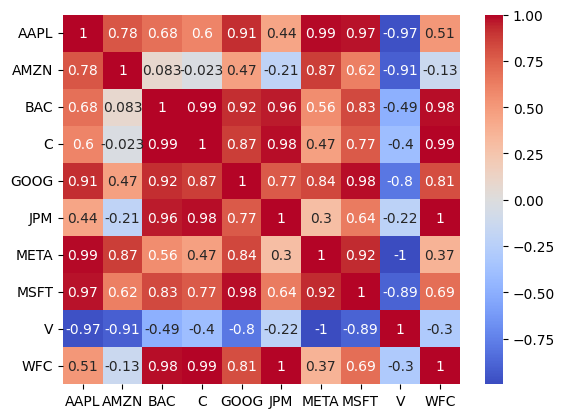

In [689]:
corr = returns_pct.corr() # calculate the correlations between the returns of each pair of stocks
corr # display the correlation matrix
sns.heatmap(corr,annot=True,cmap="coolwarm")

In [690]:
df = pd.DataFrame(corr)

# get the column names
titles = df.columns.tolist()


In [691]:
def truncate(f): # define a function that "rounds" a number to 0 if it is lower than 0.92, and to 1 if it is higher (or equal).
    if (abs(f) < 0.84):
        return 0.
    else:
        return 1
    
# we already know that every stock is perfectly correlated with itself, so the ones on the diagonal are not really useful information. Let's get rid of them.
adj = corr.applymap(truncate) - np.identity(10)
adj

,AAPL,AMZN,BAC,C,GOOG,JPM,META,MSFT,V,WFC
AAPL,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
AMZN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
BAC,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
C,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
GOOG,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
JPM,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
META,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
MSFT,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
V,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
WFC,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [692]:
stocknet = nx.from_numpy_array(adj.to_numpy()) # initialize a new graph from our adjacency matrix
istocknet=stocknet
istock_layout = nx.spring_layout(istocknet,seed=10)
stocknet = nx.relabel_nodes(stocknet, dict(enumerate(adj.columns))) # keep the stock tickers as the names of the nodes (instead of integers)
stock_layout = nx.spring_layout(stocknet,seed=10) # fix our layout
#nx.draw(stocknet,stock_layout) # plot the graph, without any labels (for now)

In [693]:
L = nx.laplacian_matrix(stocknet).todense()
(u,v) = np.linalg.eig(L)
u_sorted = np.sort(u)
v_sorted = v[:, u.argsort()]
colors = [ "lightcoral" for i in range(0,10) ]
for i in range(0,10):
    if (v_sorted[i,1] < 0):
        colors[i] = "mediumpurple"
        
#nx.draw(stocknet,stock_layout,node_color=colors,with_labels=True)

In [694]:
eigen_cent = nx.eigenvector_centrality(istocknet)
eigen_colors = [eigen_cent[i] for i in range(0,10)]
#nx.draw(istocknet,istock_layout,node_color=eigen_colors,with_labels=True)
#nx.draw(stocknet,stock_layout)

In [695]:
print(eigen_cent)

{0: 0.39737272729863704, 1: 0.1930909355409745, 2: 0.2868635377557129, 3: 0.2868635377557129, 4: 0.3661417312184826, 5: 0.20957846802750935, 6: 0.36084505494863567, 7: 0.39737272729863704, 8: 0.36084505494863567, 9: 0.20957846802750935}


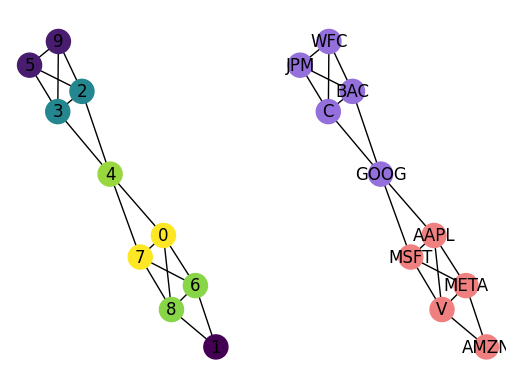

In [696]:
# Create two example graphs
G1 = nx.complete_graph(5)
G2 = nx.cycle_graph(6)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2)

# Draw the graphs in the subplots
nx.draw(istocknet,istock_layout,node_color=eigen_colors,with_labels=True,ax=ax1)
nx.draw(stocknet,stock_layout,node_color=colors,with_labels=True,ax=ax2)

plt.show()

In [697]:
#df = pd.DataFrame(eigen_cent)
print(eigen_cent)
#stocknet = nx.relabel_nodes(stocknet, dict(enumerate(adj.columns)))

{0: 0.39737272729863704, 1: 0.1930909355409745, 2: 0.2868635377557129, 3: 0.2868635377557129, 4: 0.3661417312184826, 5: 0.20957846802750935, 6: 0.36084505494863567, 7: 0.39737272729863704, 8: 0.36084505494863567, 9: 0.20957846802750935}


In [698]:

df = pd.DataFrame(eigen_cent,index=[0])
dfT= pd.DataFrame(titles)
# print the resulting DataFrame
mat1=df.T
mat2=dfT

joined_mat = pd.concat([mat1, mat2], axis=1)
df=joined_mat
# print the resulting joined matrix
joined_mat.head()
df.columns = ['centrality', 'stock']
df = df.iloc[:, [1, 0]]
df = df.sort_values('centrality',ascending=False)
df=df.reset_index(drop=True)
centralitydf=df

print(centralitydf)
print(centralitydf['stock'])

  stock  centrality
0  AAPL    0.397373
1  MSFT    0.397373
2  GOOG    0.366142
3  META    0.360845
4     V    0.360845
5   BAC    0.286864
6     C    0.286864
7   JPM    0.209578
8   WFC    0.209578
9  AMZN    0.193091
0    AAPL
1    MSFT
2    GOOG
3    META
4       V
5     BAC
6       C
7     JPM
8     WFC
9    AMZN
Name: stock, dtype: object


In [699]:
start_date = datetime.strptime("2023-04-1", "%Y-%m-%d")+ timedelta(days=6)
end_date = datetime.strptime("2023-04-8", "%Y-%m-%d") + timedelta(days=7)
end_date = end_date.strftime("%Y-%m-%d")


data = yf.download(tickers, start=start_date, end=end_date)
dataOpen = data["Open"]
print(dataOpen.head())


[*********************100%***********************]  10 of 10 completed
                  AAPL        AMZN        BAC          C        GOOG   
Date                                                                   
2023-04-10  161.419998  100.959999  27.670000  45.790001  107.389999  \
2023-04-11  162.350006  100.800003  28.020000  46.669998  106.919998   
2023-04-12  161.220001  100.400002  28.680000  47.480000  107.389999   
2023-04-13  161.630005   98.949997  28.559999  46.900002  106.470001   
2023-04-14  164.589996  102.070000  29.299999  48.169998  107.690002   

                   JPM        META        MSFT           V        WFC  
Date                                                                   
2023-04-10  126.540001  214.710007  289.209991  225.559998  37.700001  
2023-04-11  128.300003  215.479996  285.750000  227.000000  38.770000  
2023-04-12  129.179993  214.839996  284.790009  229.929993  39.419998  
2023-04-13  128.460007  215.729996  283.589996  229.460007  39.3

In [700]:
returns_pct = dataOpen.pct_change()
#returns_pct = returns_pct.drop(returns_pct.index[0])


In [701]:
returns_pct.head()

,AAPL,AMZN,BAC,C,GOOG,JPM,META,MSFT,V,WFC
Date,,,,,,,,,,
2023-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-11,0.005761,-0.001585,0.012649,0.019218,-0.004377,0.013909,0.003586,-0.011964,0.006384,0.028382
2023-04-12,-0.006960,-0.003968,0.023555,0.017356,0.004396,0.006859,-0.002970,-0.003360,0.012907,0.016765
2023-04-13,0.002543,-0.014442,-0.004184,-0.012216,-0.008567,-0.005574,0.004143,-0.004214,-0.002044,-0.002537
2023-04-14,0.018313,0.031531,0.025910,0.027079,0.011459,0.052078,0.009966,0.012024,0.015384,0.010936


In [707]:

data = returns_pct
df = pd.DataFrame(data)
print(df)
# choose a row to compute the weighted sum of
row_to_sum = 1

# specify the weights as a list or array (here, we use equally weighted values)
weights = [1, 1/2, 1/4,1/8,1/16,1/32,1/64,1/128,1/256,1/512]

# compute the weighted sum of the row
weighted_sum = (df.iloc[row_to_sum, :] * weights).sum()

NominalReturns=weighted_sum
# print the weighted sum of the row
print(f"The weighted sum of row {row_to_sum} is {weighted_sum}")


                AAPL      AMZN       BAC         C      GOOG       JPM   
Date                                                                     
2023-04-10       NaN       NaN       NaN       NaN       NaN       NaN  \
2023-04-11  0.005761 -0.001585  0.012649  0.019218 -0.004377  0.013909   
2023-04-12 -0.006960 -0.003968  0.023555  0.017356  0.004396  0.006859   
2023-04-13  0.002543 -0.014442 -0.004184 -0.012216 -0.008567 -0.005574   
2023-04-14  0.018313  0.031531  0.025910  0.027079  0.011459  0.052078   

                META      MSFT         V       WFC  
Date                                                
2023-04-10       NaN       NaN       NaN       NaN  
2023-04-11  0.003586 -0.011964  0.006384  0.028382  
2023-04-12 -0.002970 -0.003360  0.012907  0.016765  
2023-04-13  0.004143 -0.004214 -0.002044 -0.002537  
2023-04-14  0.009966  0.012024  0.015384  0.010936  
The weighted sum of row 1 is 0.01073762967293742


In [712]:
date = '2022-05-10'

# Set the investment horizon to 1 day
investment_horizon = 0

# Get today's date
today ='2022-05-10'

# Calculate the end date for the investment horizon
end_date = (datetime.today() + timedelta(days=investment_horizon)).strftime('%Y-%m-%d')

# Retrieve the daily Treasury bill yield for the investment horizon
risk_free_ticker = yf.Ticker("^IRX")
risk_free_data = risk_free_ticker.history(start=today, end=end_date)
risk_free_rate = risk_free_data["Close"][0]/100
print(risk_free_rate)

0.008780000209808349


In [714]:
ExcessReturns=NominalReturns-risk_free_rate
print(ExcessReturns)


0.0019576294631290705


In [624]:


dataOpen = dataOpen.reset_index().drop(columns=['Date'])
dataOpen.head()


,AAPL,AMZN,BAC,C,GOOG,JPM,META,MSFT,V,WFC
0,164.740005,103.910004,27.660000,45.470001,106.120003,126.800003,214.149994,285.850006,226.779999,36.500000
1,162.429993,100.750000,27.719999,45.799999,105.769997,127.000000,209.250000,283.209991,226.160004,37.110001
2,161.419998,100.959999,27.670000,45.790001,107.389999,126.540001,214.710007,289.209991,225.559998,37.700001
3,162.350006,100.800003,28.020000,46.669998,106.919998,128.300003,215.479996,285.750000,227.000000,38.770000
4,161.220001,100.400002,28.680000,47.480000,107.389999,129.179993,214.839996,284.790009,229.929993,39.419998


In [685]:
returns_pct = dataOpen.pct_change()
returns_pct = returns_pct.drop(returns_pct.index[0])
returns_pct.head()
#returns.head()


,AAPL,AMZN,BAC,C,GOOG,JPM,META,MSFT,V,WFC
Date,,,,,,,,,,
2023-04-11,0.005761,-0.001585,0.012649,0.019218,-0.004377,0.013909,0.003586,-0.011964,0.006384,0.028382
2023-04-12,-0.006960,-0.003968,0.023555,0.017356,0.004396,0.006859,-0.002970,-0.003360,0.012907,0.016765
2023-04-13,0.002543,-0.014442,-0.004184,-0.012216,-0.008567,-0.005574,0.004143,-0.004214,-0.002044,-0.002537
2023-04-14,0.018313,0.031531,0.025910,0.027079,0.011459,0.052078,0.009966,0.012024,0.015384,0.010936


In [686]:

# flatten the column index
#data.columns = data.columns.droplevel()

# print the modified DataFrame
#print(dataClose.head())
dataClose = dataClose.reset_index().drop(columns=['Date'])

returns_pct = dataClose.pct_change()
returns_pct = returns_pct.drop(returns_pct.index[0])
returns_pct.head()
#returns.head()



KeyError: "['Date'] not found in axis"

In [122]:
decay=1
decay_coeff=1/2
def buy_algo (centralitydf,decay,decay_coeff):
    for x in range(0,10)
        buy.df[x]*decay
        decay=decay*decay_coeff
        
def decay_optimizer():
    df=[]
    for x in np.linspace(0, 1, 10)
        df=df.append(buy_algo(cetranlitydf,decay,decay_coeff=x))
        #make code that extracts decay_coeff
        optimal=max(df)
    return optimal,  

    

SyntaxError: expected ':' (2741352801.py, line 4)

In [51]:
from scipy.optimize import minimize_scalar

# Define the function to be optimized
def my_func(x):
    return x**2 - 4*x + 3

# Set the range over which to optimize the function
x_range = (-10, 10)

# Use the minimize_scalar function to find the minimum value of the function within the given range
result = minimize_scalar(my_func, bounds=x_range)

# Print the minimum value and the value of x at which it occurs
print("Minimum value:", result.fun)
print("Optimal x value:", result.x)

Minimum value: -1.0
Optimal x value: 2.0
